# Classifying cell images as uninfected or parasitized with malaria using the fastAI library and resnet50 architecture

[FastAI](https://www.fast.ai/) is a python library for making it quick and easy to build deep learning models using [pytorch](https://pytorch.org/).

Data for this project comes from kaggle https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria

I have no prior experience with scrutinising cell images, do not know the quality of the dataset, and so this model should not be used for anything other than experimentation with models.

To highlight the pitfalls of this kind of work, I think this comment from the kaggle page for this dataset is insightful and makes sense:
https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria/discussion/104600

>Hi. The problem with this data set is that all the models or networks developed do not actually detect malaria specifically. The main difference between infected and noninfected red blood cells in the data set is that infected cells have inclusions in the cells themselves. So any machine learning model will simply separate the data based on that alone, and get high accuracy. However, there are other diseases or cells that have inclusions in them. For example, I created a CNN with 96% accuracy. But I input into the network a cell infected with babesiosis, and it produced an 80% probability. A reticulocyte is a immature red blood cell that has some inclusion in the cells. That came out with a 81% probability.   -- [zhechen](https://www.kaggle.com/zhechen23)

I used Anaconda to manage my environment and packages for this work. This inclusion should be enough, assuming you have hardware compatible with cuda and pytorch: ```conda install -c pytorch -c fastai -c conda-forge fastai```

In [35]:
import fastai; fastai.__version__

'1.0.57'

However, I did this work in 2019 using fastai v1.0.57, and there are regular changes to the fastai library, so if things aren't working, you may need to search the fastai forums/update notes to see if a particular function has changed.

In [1]:
from fastai.vision import *

Modify the path below to point to wherever you store the images downloaded from kaggle, if you wish to run this notebook yourself.

In [2]:
path = Path('../Datasets/cell_images/')

In [3]:
path.ls()

[PosixPath('../Datasets/cell_images/Uninfected'),
 PosixPath('../Datasets/cell_images/models'),
 PosixPath('../Datasets/cell_images/Parasitized')]

## The data

In [4]:
np.random.seed(7)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.25,
        ds_tfms=get_transforms(flip_vert=True, max_warp=None, max_rotate=25), size=224).normalize(imagenet_stats)

As shown below, the data includes images of cell bodies. I decided that it would be ok to augment  my dataset with horizontal and vertical flips and rotations, and elected to avoid perspective warping transformations - I couldn't be sure that simulating viewing of images from oblique angles would be correct, given microscope slides tend be flat (almost 2D) and have a single viewing perspective.

Intuition: it looks as though parasitized images might have a deep magenta coloured spot (inclusion) somewhere in the mage, while uninfected images do not. I'm guessing a stain of some sort has been applied to the images to highlight foreign parasites.

I'm not sure why the black boudning area is a different shape in each image, perhaps each image has been manually vignetted like this to highlight the shape of the actual cell in question. The image classifier I train might be sensitive to this black shape too if the shape also correlates with the labels to some degree.

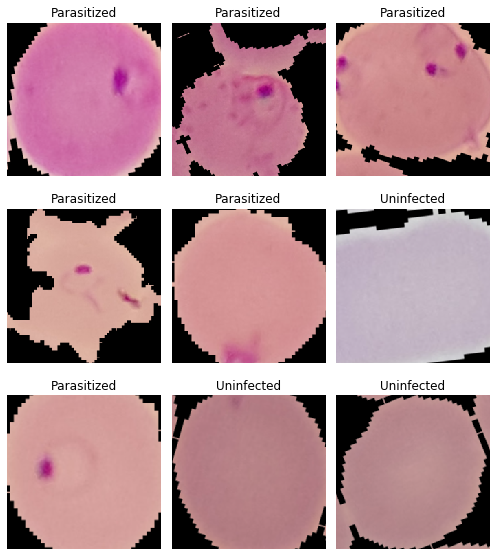

In [20]:
data.show_batch(rows=3, figsize=(7,8))

In [21]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Parasitized', 'Uninfected'], 2, 20669, 6889)

## Train model

In [7]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

`lr_find` is a nifty fastai function to help generate a plot of loss vs learning rate.

In [9]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


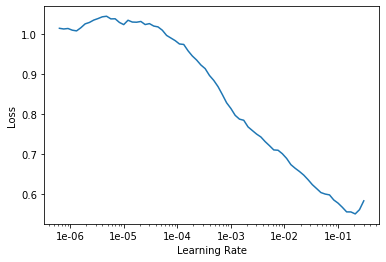

In [10]:
learn.recorder.plot()

After some experimentation, I chose a learning rate of 1e-03, (rule of thumb is to choose a value part way down the loss vs learning rate curve, but not right at the bottom), and 10 epochs seemed to work well. Validation loss has not begun to increase, and is also still lower than training loss, suggesting no great risk of overfitting. I could possibly even train for longer, or with a slightly higher learning rate

In [23]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.229611,0.151595,0.943388,01:28
1,0.154527,0.107717,0.959065,01:28
2,0.132009,0.097337,0.966613,01:28
3,0.120101,0.096341,0.964581,01:28
4,0.112308,0.081374,0.971113,01:28
5,0.107568,0.076427,0.972275,01:28
6,0.097680,0.073901,0.973291,01:28
7,0.100707,0.072248,0.973436,01:29
8,0.088327,0.068950,0.974887,01:29
9,0.082256,0.068280,0.974597,01:29


In [24]:
learn.save('stage-1')

In [25]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (20669 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Uninfected,Uninfected,Uninfected,Uninfected,Uninfected
Path: ../Datasets/cell_images;

Valid: LabelList (6889 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Parasitized,Parasitized,Uninfected,Uninfected,Parasitized
Path: ../Datasets/cell_images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): Batch

The fastai library makes it easy to us 'transfer learning'. I am starting with a resnet50 model trained on ImageNet, and then so far I have just been training the last layer at the end of this pre-trained model. I am making use of all that prior image processing knowledge developed in resnet50 and doing a comparatively much smaller training job here to adapt the model to the cell image data I am working with. This is 'transfer learning'. Next step is to 'unfreeze' all layers and do some gentle training to tweak the rest of the model a little and see if I can improve the results further.

In [26]:
learn.unfreeze()

In [27]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


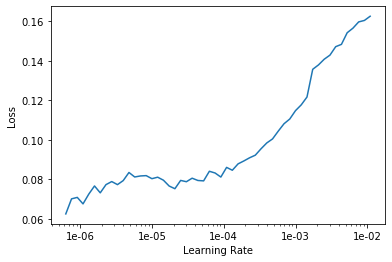

In [28]:
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.085880,0.068765,0.974597,01:55
1,0.091232,0.068711,0.974887,01:55
2,0.074427,0.067711,0.975178,01:55
3,0.093029,0.069822,0.975468,01:55


97.5% accuracy

In [30]:
learn.save('stage-2')

## Interpretation

In [8]:
learn.load('stage-2');

In [9]:
interp = ClassificationInterpretation.from_learner(learn)

Had to do a bit of additional tweaking with the confusion matrix plot below, because it wasn't displaying correctly with just `interp.plot_confusion_matrix()`

(1.5, -0.5)

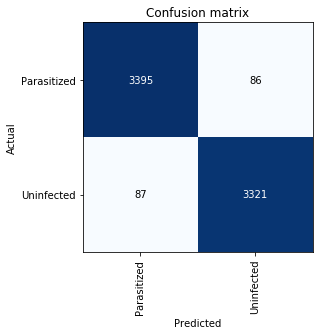

In [25]:
cm_fig = interp.plot_confusion_matrix(return_fig=True)
ax = cm_fig.gca()
ax.set_ylim(interp.data.c - .5, - .5)

Below I plot a selection of images that had the biggest disparity between prediction and actual, to get some insight into why the model is struggling in these cases

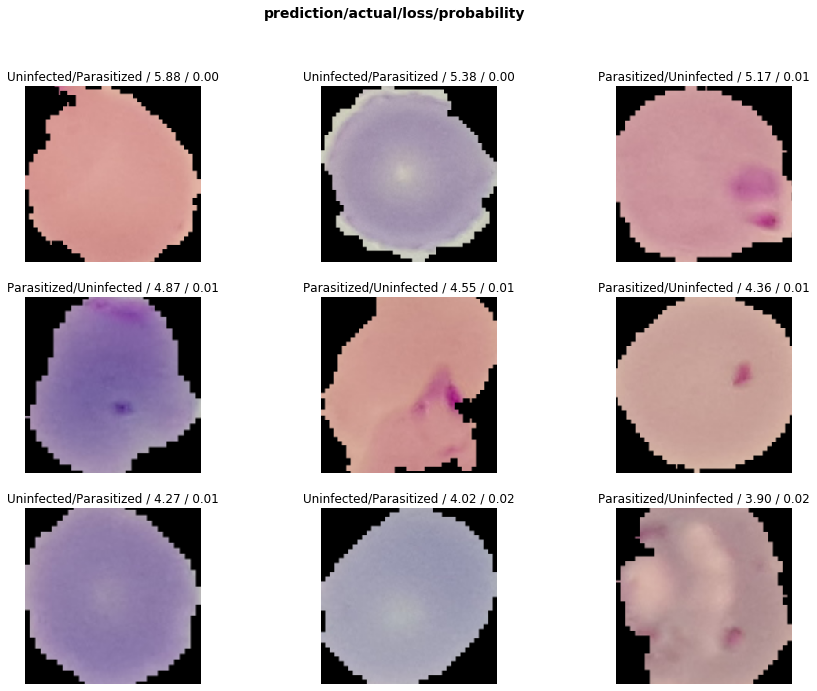

In [32]:
interp.plot_top_losses(9, figsize=(15,11))

OK, so I'm no specialist at studying whether a cell is infected with a parasite or not by looking at microscope images. However, on the intuition that having a magenta spot somewhere is an indication of parasitization, it seems possible that some of the training images are mislabelled.